*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/nlp-with-pytorch/blob/master/chapter_7/7_3_surname_generation/7_3_Model2_Conditioned_Surname_Generation.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/nlp-with-pytorch/blob/master/chapter_7/7_3_surname_generation/7_3_Model2_Conditioned_Surname_Generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

# 성씨 생성

## 임포트

In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

## 데이터 벡터화 클래스

### Vocabulary

In [2]:
class Vocabulary(object):
    """매핑을 위해 텍스트를 처리하고 어휘 사전을 만드는 클래스 """

    def __init__(self, token_to_idx=None):
        """
        매개변수:
            token_to_idx (dict): 기존 토큰-인덱스 매핑 딕셔너리
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}

    def to_serializable(self):
        """ 직렬화할 수 있는 딕셔너리를 반환합니다 """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ 직렬화된 딕셔너리에서 Vocabulary 객체를 만듭니다 """
        return cls(**contents)

    def add_token(self, token):
        """ 토큰을 기반으로 매핑 딕셔너리를 업데이트합니다

        매개변수:
            token (str): Vocabulary에 추가할 토큰
        반환값:
            index (int): 토큰에 상응하는 정수
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """토큰 리스트를 Vocabulary에 추가합니다.

        매개변수:
            tokens (list): 문자열 토큰 리스트
        반환값:
            indices (list): 토큰 리스트에 상응되는 인덱스 리스트
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """토큰에 대응하는 인덱스를 추출합니다.

        매개변수:
            token (str): 찾을 토큰
        반환값:
            index (int): 토큰에 해당하는 인덱스
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """ 인덱스에 해당하는 토큰을 반환합니다.

        매개변수:
            index (int): 찾을 인덱스
        반환값:
            token (str): 인텍스에 해당하는 토큰
        에러:
            KeyError: 인덱스가 Vocabulary에 없을 때 발생합니다.
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """ 토큰에 대응하는 인덱스를 추출합니다.
        토큰이 없으면 UNK 인덱스를 반환합니다.

        매개변수:
            token (str): 찾을 토큰
        반환값:
            index (int): 토큰에 해당하는 인덱스
        노트:
            UNK 토큰을 사용하려면 (Vocabulary에 추가하기 위해)
            `unk_index`가 0보다 커야 합니다.
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

### Vectorizer

In [4]:
class SurnameVectorizer(object):
    """ 어휘 사전을 생성하고 관리합니다 """
    def __init__(self, char_vocab, nationality_vocab):
        """
        매개변수:
            char_vocab (SequenceVocabulary): 문자를 정수로 매핑합니다
            nationality_vocab (Vocabulary): 국적을 정수로 매핑합니다
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """ 성씨를 샘플과 타깃 벡터로 변환합니다

        성씨 벡터를 두 개의 벡터 surname[:-1]와 surname[1:]로 나누어 출력합니다.
        각 타임스텝에서 첫 번째 벡터가 샘플이고 두 번째 벡터가 타깃입니다.

        매개변수:
            surname (str): 벡터로 변경할 성씨
            vector_length (int): 인덱스 벡터의 길이를 맞추기 위한 매개변수
        반환값:
            튜플: (from_vector, to_vector)
                from_vector (numpy.ndarray): 샘플 벡터
                to_vector (numpy.ndarray): 타깃 벡터 vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices) - 1

        from_vector = np.zeros(vector_length, dtype=np.int64)
        from_indices = indices[:-1]
        from_vector[:len(from_indices)] = from_indices
        from_vector[len(from_indices):] = self.char_vocab.mask_index

        to_vector = np.zeros(vector_length, dtype=np.int64)
        to_indices = indices[1:]
        to_vector[:len(to_indices)] = to_indices
        to_vector[len(to_indices):] = self.char_vocab.mask_index

        return from_vector, to_vector

    @classmethod
    def from_dataframe(cls, surname_df):
        """데이터셋 데이터프레임으로 객체를 초기화합니다

        매개변수:
            surname_df (pandas.DataFrame): 성씨 데이터셋
        반환값:
            SurnameVectorizer 객체
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """파일에서 SurnameVectorizer 객체를 초기화합니다

        매개변수:
            contents (dict): SurnameVectorizer를 위해 두 개의 어휘 사전을 담은 딕셔너리
                이 딕셔너리는 `vectorizer.to_serializable()`를 사용해 만듭니다
        반환값:
            SurnameVectorizer의 객체
        """
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nat_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])

        return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

    def to_serializable(self):
        """ 직렬화된 결과를 반환합니다 """
        return {'char_vocab': self.char_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}

### Dataset

In [5]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        매개변수:
            surname_df (pandas.DataFrame): 데이터셋
            vectorizer (SurnameVectorizer): 데이터셋에서 만든 Vectorizer 객체
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """데이터셋을 로드하고 새로운 Vectorizer를 만듭니다

        매개변수:
            surname_csv (str): 데이터셋의 위치
        반환값:
            SurnameDataset 객체
        """
        surname_df = pd.read_csv(surname_csv)
        return cls(surname_df, SurnameVectorizer.from_dataframe(surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """데이터셋과 새로운 Vectorizer 객체를 로드합니다.
        캐싱된 Vectorizer 객체를 재사용할 때 사용합니다.

        매개변수:
            surname_csv (str): 데이터셋의 위치
            vectorizer_filepath (str): Vectorizer 객체의 저장 위치
        반환값:
            SurnameDataset의 인스턴스
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """파일에서 Vectorizer 객체를 로드하는 정적 메서드

        매개변수:
            vectorizer_filepath (str): 직렬화된 Vectorizer 객체의 위치
        반환값:
            SurnameVectorizer의 인스턴스
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """Vectorizer 객체를 json 형태로 디스크에 저장합니다

        매개변수:
            vectorizer_filepath (str): Vectorizer 객체의 저장 위치
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ 벡터 변환 객체를 반환합니다 """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """파이토치 데이터셋의 주요 진입 메서드

        매개변수:
            index (int): 데이터 포인트에 대한 인덱스
        반환값:
            데이터 포인트(x_data, y_target, class_index)를 담고 있는 딕셔너리
        """
        row = self._target_df.iloc[index]

        from_vector, to_vector = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': from_vector,
                'y_target': to_vector,
                'class_index': nationality_index}

    def get_num_batches(self, batch_size):
        """배치 크기가 주어지면 데이터셋으로 만들 수 있는 배치 개수를 반환합니다

        매개변수:
            batch_size (int)
        반환값:
            배치 개수
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    파이토치 DataLoader를 감싸고 있는 제너레이터 함수.
    걱 텐서를 지정된 장치로 이동합니다.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [6]:
x = torch.ones(5, 5)

In [7]:
x = x.to("cuda")

In [8]:
y = torch.zeros(5)
y

tensor([0., 0., 0., 0., 0.])

In [9]:
y.to(x.device)

tensor([0., 0., 0., 0., 0.], device='cuda:0')

## 모델: SurnameGenerationModel

In [10]:
class SurnameGenerationModel(nn.Module):
    def __init__(self, char_embedding_size, char_vocab_size, num_nationalities,
                 rnn_hidden_size, batch_first=True, padding_idx=0, dropout_p=0.5):
        """
        매개변수:
            char_embedding_size (int): 문자 임베딩 크기
            char_vocab_size (int): 임베딩될 문자 개수
            rnn_hidden_size (int): RNN의 은닉 상태 크기
            batch_first (bool): 0번째 차원이 배치인지 시퀀스인지 나타내는 플래그
            padding_idx (int): 텐서 패딩을 위한 인덱스;
                torch.nn.Embedding를 참고하세요
            dropout_p (float): 드롭아웃으로 활성화 출력을 0으로 만들 확률
        """
        super(SurnameGenerationModel, self).__init__()

        self.char_emb = nn.Embedding(num_embeddings=char_vocab_size,
                                     embedding_dim=char_embedding_size,
                                     padding_idx=padding_idx)

        self.nation_emb = nn.Embedding(num_embeddings=num_nationalities,
                                       embedding_dim=rnn_hidden_size)

        self.rnn = nn.GRU(input_size=char_embedding_size,
                          hidden_size=rnn_hidden_size,
                          batch_first=batch_first)

        self.fc = nn.Linear(in_features=rnn_hidden_size,
                            out_features=char_vocab_size)

        self._dropout_p = dropout_p

    def forward(self, x_in, nationality_index, apply_softmax=False):
        """모델의 정방향 계산

        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서
                x_in.shape는 (batch, max_seq_size)입니다.
            nationality_index (torch.Tensor): 각 데이터 포인트를 위한 국적 인덱스
                RNN의 은닉 상태를 초기화하는데 사용합니다.
            apply_softmax (bool): 소프트맥스 활성화를 위한 플래그로 훈련시에는 False가 되어야 합니다.
        반환값:
            결과 텐서. tensor.shape는 (batch, char_vocab_size)입니다.
        """
        x_embedded = self.char_emb(x_in)

        # hidden_size: (num_layers * num_directions, batch_size, rnn_hidden_size)
        nationality_embedded = self.nation_emb(nationality_index).unsqueeze(0)

        y_out, _ = self.rnn(x_embedded, nationality_embedded)

        batch_size, seq_size, feat_size = y_out.shape
        y_out = y_out.contiguous().view(batch_size * seq_size, feat_size)

        y_out = self.fc(F.dropout(y_out, p=self._dropout_p))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        new_feat_size = y_out.shape[-1]
        y_out = y_out.view(batch_size, seq_size, new_feat_size)

        return y_out

In [11]:
def sample_from_model(model, vectorizer, nationalities, sample_size=20,
                      temperature=1.0):
    """모델이 만든 인덱스 시퀀스를 샘플링합니다.

    매개변수:
        model (SurnameGenerationModel): 훈련 모델
        vectorizer (SurnameVectorizer): SurnameVectorizer 객체
        nationalities (list): 국적을 나타내는 정수 리스트
        sample_size (int): 샘플의 최대 길이
        temperature (float): 무작위성 정도
            0.0 < temperature < 1.0 이면 최대 값을 선택할 가능성이 높습니다
            temperature > 1.0 이면 균등 분포에 가깝습니다
    반환값:
        indices (torch.Tensor): 인덱스 행렬
        shape = (num_samples, sample_size)
    """
    num_samples = len(nationalities)
    begin_seq_index = [vectorizer.char_vocab.begin_seq_index
                       for _ in range(num_samples)]
    begin_seq_index = torch.tensor(begin_seq_index,
                                   dtype=torch.int64).unsqueeze(dim=1)
    indices = [begin_seq_index]
    nationality_indices = torch.tensor(nationalities, dtype=torch.int64).unsqueeze(dim=0)
    h_t = model.nation_emb(nationality_indices)

    for time_step in range(sample_size):
        x_t = indices[time_step]
        x_emb_t = model.char_emb(x_t)
        rnn_out_t, h_t = model.rnn(x_emb_t, h_t)
        prediction_vector = model.fc(rnn_out_t.squeeze(dim=1))
        probability_vector = F.softmax(prediction_vector / temperature, dim=1)
        indices.append(torch.multinomial(probability_vector, num_samples=1))
    indices = torch.stack(indices).squeeze().permute(1, 0)
    return indices

def decode_samples(sampled_indices, vectorizer):
    """인덱스를 성씨 문자열로 변환합니다

    매개변수:
        sampled_indices (torch.Tensor): `sample_from_model` 함수에서 얻은 인덱스
        vectorizer (SurnameVectorizer): SurnameVectorizer 객체
    """
    decoded_surnames = []
    vocab = vectorizer.char_vocab

    for sample_index in range(sampled_indices.shape[0]):
        surname = ""
        for time_step in range(sampled_indices.shape[1]):
            sample_item = sampled_indices[sample_index, time_step].item()
            if sample_item == vocab.begin_seq_index:
                continue
            elif sample_item == vocab.end_seq_index:
                break
            else:
                surname += vocab.lookup_index(sample_item)
        decoded_surnames.append(surname)
    return decoded_surnames

## 훈련 과정

### 헬퍼 함수

In [12]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """훈련 상태를 업데이트합니다.

    콤포넌트:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= loss_tm1:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    """텐서 크기 정규화

    매개변수:
        y_pred (torch.Tensor): 모델의 출력
            3차원 텐서이면 행렬로 변환합니다.
        y_true (torch.Tensor): 타깃 예측
            행렬이면 벡터로 변환합니다.
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)

    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()

    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

### 일반 유틸리티

In [13]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### 설정

In [14]:
args = Namespace(
    # 날짜와 경로 정보
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch7/model2_conditioned_surname_generation",
    # 모델 하이퍼파라미터
    char_embedding_size=32,
    rnn_hidden_size=32,
    # 훈련 하이퍼파라미터
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # 실행 옵션
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)

    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("CUDA 사용 여부: {}".format(args.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	model_storage/ch7/model2_conditioned_surname_generation/vectorizer.json
	model_storage/ch7/model2_conditioned_surname_generation/model.pth
CUDA 사용 여부: True


In [15]:
# 만약 코랩에서 실행하는 경우 아래 코드를 실행하여 전처리된 데이터를 다운로드하세요.
!mkdir data
!wget https://git.io/Jqfup -O data/download.py
!wget https://git.io/Jqfze -O data/get-all-data.sh
!chmod 755 data/get-all-data.sh
%cd data
!./get-all-data.sh
%cd ..

--2024-06-14 05:20:43--  https://git.io/Jqfup
Resolving git.io (git.io)... 140.82.113.21
Connecting to git.io (git.io)|140.82.113.21|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_7/7_3_surname_generation/data/download.py [following]
--2024-06-14 05:20:44--  https://raw.githubusercontent.com/rickiepark/nlp-with-pytorch/main/chapter_7/7_3_surname_generation/data/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572 (1.5K) [text/plain]
Saving to: ‘data/download.py’

data/download.py    100%[===================>]   1.54K  --.-KB/s    in 0s      

2024-06-14 05:20:44 (24.8 MB/s) - ‘data/download.py’ saved [1572/1572]

--2024-06-14 05:

### 초기화

In [16]:
if args.reload_from_files:
    # 체크포인트를 로드합니다.
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer를 만듭니다.
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               num_nationalities=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index,
                               dropout_p=0.5)

### 모델 훈련

In [17]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine',
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size),
                               position=1,
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size),
                             position=1,
                             leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = model(x_in=batch_dict['x_data'],
                           nationality_index=batch_dict['class_index'])

            # 단계 3. 손실을 계산합니다
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------

            # 이동 손실과 이동 정확도를 계산합니다
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 단계 1. 출력을 계산합니다
            y_pred = model(x_in=batch_dict['x_data'],
                           nationality_index=batch_dict['class_index'])

            # 단계 2. 손실을 계산합니다
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # 단계 3. 이동 손실과 이동 정확도를 계산합니다
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            val_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        # 샘플링을 위해 모델을 cpu로 옮깁니다
        nationalities = np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, nationalities=nationalities),
            vectorizer)

        sample1 = "{}->{}".format(vectorizer.nationality_vocab.lookup_index(nationalities[0]),
                                  sampled_surnames[0])
        sample2 = "{}->{}".format(vectorizer.nationality_vocab.lookup_index(nationalities[1]),
                                  sampled_surnames[1])
        epoch_bar.set_postfix(sample1=sample1,
                              sample2=sample2)
        # 원래 장치로 모델을 이동합니다
        model = model.to(args.device)

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

except KeyboardInterrupt:
    print("반복 중지")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/60 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

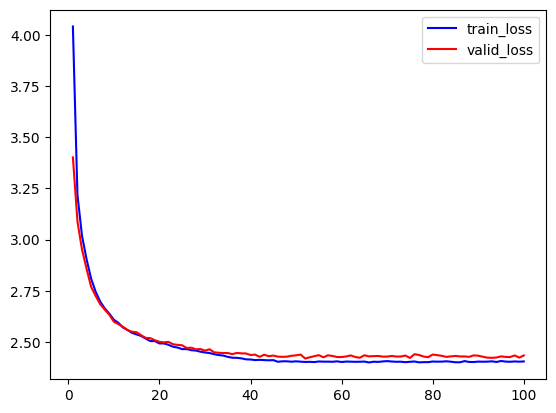

In [22]:
import matplotlib.pyplot as plt

train_loss = train_state['train_loss']
valid_loss = train_state['val_loss']

epochs = range(1, len(train_loss)+1)

plt.plot(epochs, train_loss, 'b-', label='train_loss')
plt.plot(epochs, valid_loss, 'r-', label='valid_loss')
plt.legend()

plt.show()

In [18]:
# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_acc = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred = model(x_in=batch_dict['x_data'],
                   nationality_index=batch_dict['class_index'])

    # 손실을 계산합니다
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # 이동 손실과 이동 정확도를 계산합니다
    running_loss += (loss.item() - running_loss) / (batch_index + 1)
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [19]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 2.4358944098154707;
테스트 정확도: 28.637298822079906


## 샘플링

In [23]:
ko_index = vectorizer.nationality_vocab.lookup_token('Korean')
ko_index

11

In [25]:
nations = [ko_index] * 3
nations

[11, 11, 11]

In [27]:
model = model.cpu()

In [28]:
sample_indices = sample_from_model(model, vectorizer, nations)
sample_indices

tensor([[ 2, 17,  7,  3,  5, 18,  3,  3, 23,  3, 23,  3,  3, 18,  3, 15,  7,  3,
         18,  3,  3],
        [ 2, 45,  5, 53,  3, 23,  3,  3,  3, 27,  3,  5,  3,  7,  3,  3,  3,  3,
         16,  5,  3],
        [ 2, 29, 23, 31, 31,  3,  3,  5, 25,  3, 23, 27,  3,  3, 23,  3, 21, 23,
         10, 16,  3]])

In [29]:
decode_samples(sample_indices, vectorizer)

['Sa', 'Jov', 'Gill']

In [31]:
vectorizer.char_vocab.begin_seq_index

2

In [30]:
vectorizer.char_vocab.end_seq_index

3

In [32]:
model = model.cpu()
for index in range(len(vectorizer.nationality_vocab)):
    nationality = vectorizer.nationality_vocab.lookup_index(index)
    print("{} 샘플: ".format(nationality))
    sampled_indices = sample_from_model(model, vectorizer,
                                        nationalities=[index] * 3,
                                        temperature=0.7)
    for sampled_surname in decode_samples(sampled_indices, vectorizer):
        print("-  " + sampled_surname)

Arabic 샘플: 
-  Barada
-  Chur
-  Baman
Chinese 샘플: 
-  Tue
-  Dars
-  Sse
Czech 샘플: 
-  Kaittaon
-  Shajta
-  Birer
Dutch 샘플: 
-  Rurodiler
-  Morert
-  Ruchlerrupt
English 샘플: 
-  Sirch
-  Coscha
-  Smaneg
French 샘플: 
-  Riann
-  Panlroni
-  Uugar
German 샘플: 
-  Suhindran
-  Layser
-  Kadg
Greek 샘플: 
-  Samine
-  Olisinari
-  Bolatig
Irish 샘플: 
-  Molaren
-  Narne
-  Mollorar
Italian 샘플: 
-  Gebowor
-  Cantanea
-  Araroer
Japanese 샘플: 
-  Igesa
-  Limaki
-  Isaky
Korean 샘플: 
-  Yas
-  Sel
-  Sul
Polish 샘플: 
-  Nadenne
-  Boorinus
-  Umin
Portuguese 샘플: 
-  Awen
-  Matoeni
-  Liis
Russian 샘플: 
-  Iachov
-  Ninhan
-  Marrin
Scottish 샘플: 
-  Augleys
-  Sirtan
-  Contal
Spanish 샘플: 
-  Tebena
-  Gianii
-  Peosrato
Vietnamese 샘플: 
-  Ker
-  Ju
-  Ka
